In [1]:
import numpy as np
import matplotlib.pyplot as plt
import src.SessionNavigator as SessionNavigator
import src.SessionProcessor as SessionProcessor
from scipy.stats import sem
from sklearn.svm import LinearSVC
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

C:\Users\Demogorgon\anaconda3\envs\Python37\lib\site-packages\allensdk\brain_observatory\comparison_utils.py:9: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
def dict_to_array(dictionary, cv_count):
    arr = np.zeros((len(dictionary), cv_count))
    for key, value in dictionary.items():
        arr[key] = value
    return arr

CV_COUNT = 10
data_root = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab"
manifest_path = f"{data_root}/AllenSDK_Data/manifest.json"
navigator = SessionNavigator.SessionNavigator(manifest_path)
acronyms = ['VISp', 'VISl', 'VISal', 'VISrl', 'VISam', 'VISpm', 'LGd']
stim = 'drifting_gratings_contrast'
session_ids = navigator.find_sessions(acronyms, genotype="wt/wt", session_type="functional_connectivity")
#sessions = [navigator.load_session(session_id) for session_id in session_ids]
session = navigator.load_session(session_ids[0])

In [3]:
processor = SessionProcessor.SessionProcessor(session)
unshuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation')
shuffled = processor.construct_decoder('drifting_gratings_contrast', 'orientation', shuffle_trials=True)

In [4]:
processor.construct_psth(unshuffled)
thorough_unshuffled_accuracies = processor.calculate_decoder_weights(unshuffled, thorough_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(unshuffled)

processor.construct_psth(shuffled)
thorough_shuffled_accuracies = processor.calculate_decoder_weights(shuffled, thorough_accuracy_scoring=True, cv_count=CV_COUNT)
processor.calculate_correlations(shuffled)

thorough_unshuffled_accuracies = dict_to_array(thorough_unshuffled_accuracies, CV_COUNT)
thorough_shuffled_accuracies = dict_to_array(thorough_shuffled_accuracies, CV_COUNT)

In [5]:
results = processor.results()
unshuffled_results = results["drifting_gratings_contrast__width_50.0ms__unshuffled"]
shuffled_results = results["drifting_gratings_contrast__width_50.0ms__shuffled"]
keys = unshuffled_results.keys()
(num_presentations, num_bins, num_units) = unshuffled_results["psths"].shape
unit_ids = processor.all_units

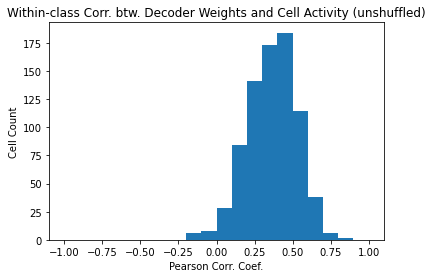

In [6]:
correlation_diagonals = unshuffled_results["within_class_correlations"]

diags = list(correlation_diagonals.values())
fig, ax = plt.subplots()
image = ax.hist(diags,bins=np.arange(-1, 1.1, 0.1))
ax.set_xlabel("Pearson Corr. Coef.")
ax.set_ylabel("Cell Count")
ax.set_title("Within-class Corr. btw. Decoder Weights and Cell Activity (unshuffled)")
plt.show()

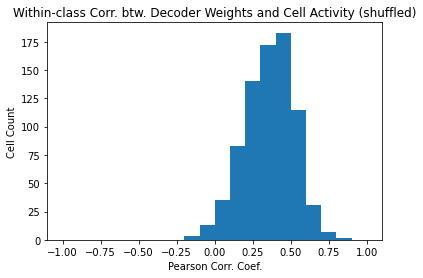

In [7]:
correlation_diagonals = shuffled_results["within_class_correlations"]

diags = list(correlation_diagonals.values())
fig, ax = plt.subplots()
image = ax.hist(diags,bins=np.arange(-1, 1.1, 0.1))
ax.set_xlabel("Pearson Corr. Coef.")
ax.set_ylabel("Cell Count")
ax.set_title("Within-class Corr. btw. Decoder Weights and Cell Activity (shuffled)")
plt.show()

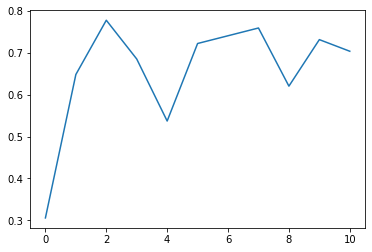

In [8]:
decoder = unshuffled_results["decoder"]
accuracies = decoder.accuracies_by_bin
x = list(accuracies.keys())
y = (accuracies.values())

fig, ax = plt.subplots()
image = ax.plot(x, y)
plt.show()

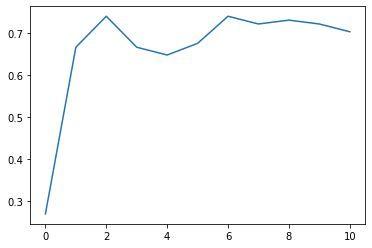

In [9]:
decoder = shuffled_results["decoder"]
accuracies = decoder.accuracies_by_bin
x = list(accuracies.keys())
y = (accuracies.values())

fig, ax = plt.subplots()
image = ax.plot(x, y)
plt.show()

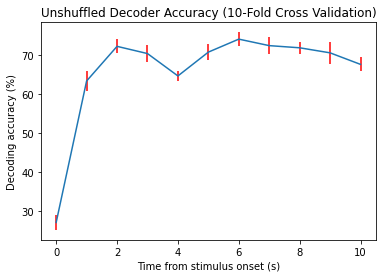

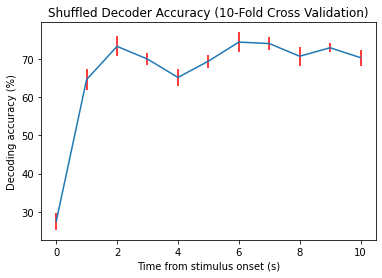

In [10]:
num_bins = thorough_unshuffled_accuracies.shape[0]
bins = list(range(num_bins))

unshuffled_sem = sem(thorough_unshuffled_accuracies, axis=1)
shuffled_sem = sem(thorough_shuffled_accuracies, axis=1)

fig, ax = plt.subplots()
ax.errorbar(bins,thorough_unshuffled_accuracies.mean(axis=1)*100,unshuffled_sem*100, ecolor='r')#, fmt='none')
#ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='g')#, fmt='none')
ax.set_xlabel('Time from stimulus onset (s)')
ax.set_ylabel('Decoding accuracy (%)')
ax.set_title('Unshuffled Decoder Accuracy (10-Fold Cross Validation)')
plt.show()

fig, ax = plt.subplots()
ax.errorbar(bins,thorough_shuffled_accuracies.mean(axis=1)*100,shuffled_sem*100, ecolor='r')#, fmt='none')
ax.set_xlabel('Time from stimulus onset (s)')
ax.set_ylabel('Decoding accuracy (%)')
ax.set_title('Shuffled Decoder Accuracy (10-Fold Cross Validation)')
plt.show()

In [11]:
unshuffled_weights = unshuffled_results["decoder"].weights_by_cell
shuffled_weights = shuffled_results["decoder"].weights_by_cell

k = 0
differences = np.zeros(len(unit_ids))
for unit_id in unit_ids:
    current_unshuffled_weights = unshuffled_weights[unit_id]#np.sort(unshuffled_weights[unit_id])
    current_shuffled_weights = shuffled_weights[unit_id]#np.sort(shuffled_weights[unit_id])
    differences[k] = (current_unshuffled_weights - current_shuffled_weights).mean()
    k += 1
differences.mean()

1.431626760927654e-05

In [12]:
#import pickle as pkl
#full_path = "C:/Users/Demogorgon/Documents/College/Marcus/Boston University PhD/Ocker Lab/correlations_and_bursts/results"
#with open(f"{full_path}/first_example_processor.pkl", 'wb') as f:
#        pkl.dump(processor, f)

In [19]:
decoder = unshuffled_results["decoder"]
# x is the presentationwise spike count. We need the presentationwise burst count
decoder_x = decoder.x # Shape: presentations, bins, units
decoder_y = decoder.y

bins = decoder.bin_edges
stim_table = session.get_stimulus_table("drifting_gratings_contrast")
stim_presentation_ids = stim_table.index.values
presentationwise_example = session.presentationwise_spike_counts(bins, stim_presentation_ids, unit_ids)